Total dataset size:
n_samples: 1560
n_features: 1850
n_classes: 12
Classification report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.75      0.77        16
     Colin Powell       0.82      0.92      0.87        66
  Donald Rumsfeld       0.72      0.85      0.78        27
    George W Bush       0.97      0.76      0.86       140
Gerhard Schroeder       0.70      0.79      0.75        24
      Hugo Chavez       0.82      0.82      0.82        17
   Jacques Chirac       0.70      0.70      0.70        10
    Jean Chretien       0.65      0.79      0.71        14
    John Ashcroft       0.70      0.88      0.78        16
Junichiro Koizumi       0.82      0.82      0.82        11
  Serena Williams       0.60      0.67      0.63         9
       Tony Blair       0.74      0.88      0.80        40

         accuracy                           0.82       390
        macro avg       0.75      0.80      0.77       390
     weighted avg      

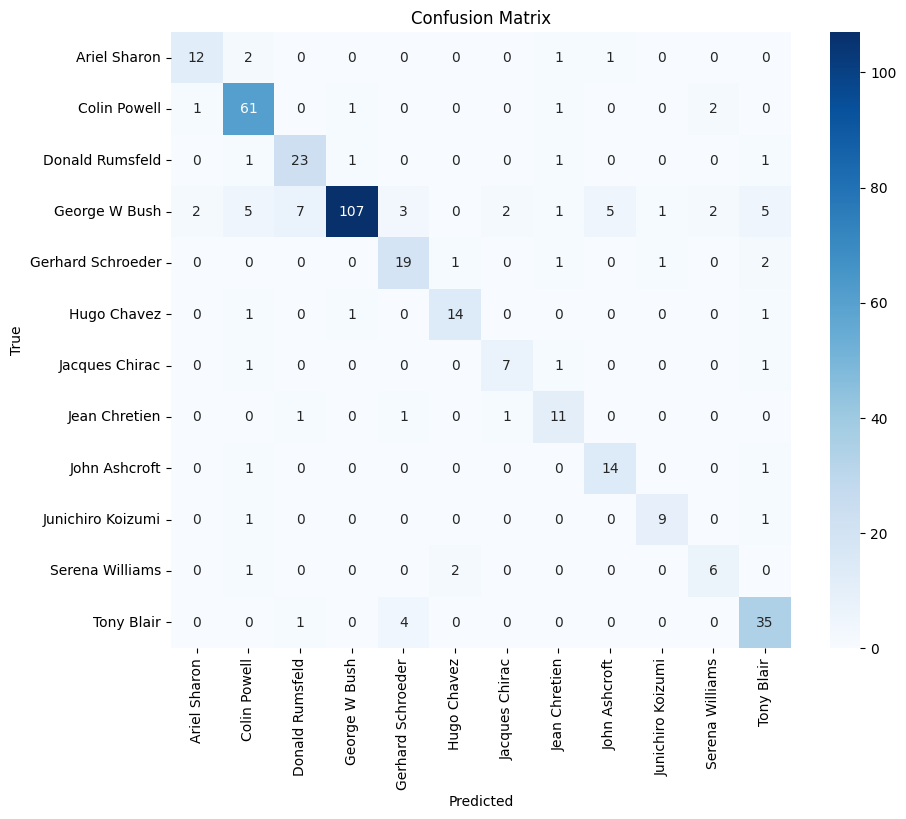

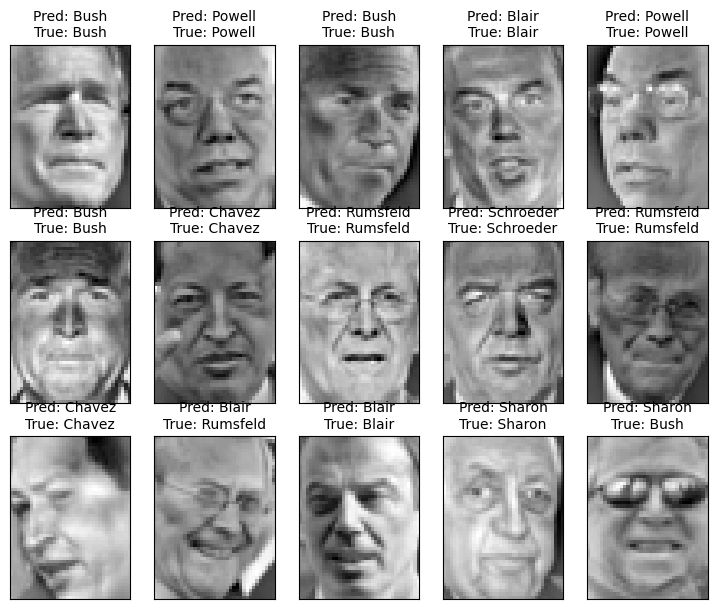

0.8153846153846154

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 

# 1. 加载 LFW 数据集
lfw_dataset = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

# 获取图像数据和标签
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
n_classes = target_names.shape[0]

print(f"Total dataset size:")
print(f"n_samples: {X.shape[0]}")
print(f"n_features: {X.shape[1]}")
print(f"n_classes: {n_classes}")

# 2. 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 3. 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. 进行 PCA 降维 (为了避免过拟合，先用 PCA 降维)
from sklearn.decomposition import PCA

n_components = 150  # 保留的主成分数量，可根据实际情况调整
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 5. 使用 LDA 提取 FisherFace 特征
lda = LDA(n_components=n_classes - 1)
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

# 6. 训练分类器 (SVM)
classifier = SVC(kernel='rbf', class_weight='balanced', probability=True)
classifier.fit(X_train_lda, y_train)

# 7. 在测试集上进行预测
y_pred = classifier.predict(X_test_lda)

# 8. 输出结果
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 9. 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 10. 显示部分预测结果
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    for i in range(n_row * n_col):
        if i >= images.shape[0]:
            break
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=10)
        plt.xticks(())
        plt.yticks(())

h = lfw_dataset.images.shape[1]
w = lfw_dataset.images.shape[2]

prediction_titles = [
    f"Pred: {target_names[y_pred[i]].split()[-1]}\nTrue: {target_names[y_test[i]].split()[-1]}"
    for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)
plt.show()

accuracy_score(y_test, y_pred)